In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.linalg import lu_factor, lu_solve
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags
from matplotlib import cm
import time
import pandas as pd
import seaborn as sns

In [2]:
# financial data 
r_input = 0.06
high_rate = 1
sigma = 0.4
S0 = 100
K = 100
T = 1

# numerical data 
m_pde = 200
n_pde = 400

In [3]:
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})

* Introduction
* pricing by Monte-Carlo
     + context
     + lower bound 
         + The problem
         + The Longstaff Schwartz Algorithm
     + upper bound 
         + The dual problem
         + Constructing the good martingale 
* Pricing by PDE 
    + General Stuff
        + Context, PDE and stuff like this
        + Well Posed PDE
    + Numerical methods
        + General numerical stuff
        + Implicit Scheme
        + Pricing of an american put
        + error of the scheme
        + (BONUS) Proposition for a better solver 
            + (BONUS) Better convergence : Richardson extrapolation
            + (BONUS) Direct method :  LU 
    + (BONUS) The impact of interest rates 
        + (BONUS) Evolution of the price with different interest rates : european vs US PUT option
        + (BONUS) Continuation and stopping region
    + (BONUS) Greeks
        + (BONUS) Delta 
        + (BONUS) Gamma
* Conclusion

### II - Pricing by PDE

#### II.1 - General stuff

##### II.1.1 - Context, PDE and stuff like this

As seen the price of an american option is the solution of an stochastic control problem, more specifically it's the case of optimal stopping problem as the primal problem consist of the search of an optimal stopping policy. 

$$
\begin{align}
    v(t,x) &= \underset{\tau \in \mathcal{T}_t}{essup} \left( \mathbb{E}^{\mathbb{Q}} \left[ Z_{\tau} \middle| \mathcal{F}_t \right] \right) \\
    &= \underset{\tau \in \mathcal{T}_t}{essup} \left( \mathbb{E}^{\mathbb{Q}} \left[ e^{-\int_{t}^{\tau} r_u du} g(S_{\tau}) \middle| \mathcal{F}_t \right] \right)
\end{align}
$$

So as stated in **non linear option pricing** v is solution to the following problem : 
$$
\begin{equation}
    \max \left( \frac{\partial v}{\partial t}(t,x) + rx \frac{\partial v}{\partial x}(t,x) + \frac{1}{2} \sigma^2 x^2 \frac{\partial v}{\partial x^2}(t,x) - r v(t,x) , g(x) - v(t,x)  \right) = 0
\end{equation}
$$

Still in the same reference, we can see that solving numerically this problem is the same as the pricing of an european option with just one extra step : taking the maximum between two values. We will therefore concentrate on the PDE and add the max between the payoff and the value of the PDE. Therefore we can just say that we solve the european version of the option and just add our condition to make it american.         

Another interesting point is to charaterize when the solution v is either found by the PDE or either the payoff, i.e : "Should the option be exercised or should I wait ?".         
This gives rise to two regions, the continuation and the stopping region which are respectively defined as :
$$
\begin{align}
    C &= \{ \left( t,x \right), \in [0,T[ \times \mathbb{R}^{+}_{*}, v(t,x) > g(x) \} \\
    D &= \{ \left( t,x \right), \in [0,T[ \times \mathbb{R}^{+}_{*}, v(t,x) = g(x) \}
\end{align}
$$

##### II.1.1 - Well-Posed PDE

As we saw earlier, the PDE part of the equation only makes sense in the continuation region and it corresponds to the pricing of an european put. Therefore we will focus on the pricing of an european put and then we will add the condition that transform the european into an US option.

For our problem to be well-posed, we need to define boundary conditions ... 
We get the following problem :
$$
\left\{
    \begin{array}{l}
        \frac{\partial v}{\partial t}(t,x) + rx \frac{\partial v}{\partial x}(t,x) + \frac{1}{2} \sigma^2 x^2 \frac{\partial v}{\partial x^2}(t,x) - r v(t,x) &= 0 \quad (t,x) \in ]0,T[ \times \mathbb{R}^{+}_{*} \\ 
        v(T,x) &= (K-x)^{+}  \quad &\forall x \in \mathbb{R}^{+} \\
        v(t,0) &= Ke^{-r(T-t)} \quad &\forall t \in [0,T] \\
        \underset{x \rightarrow + \infty}{\lim} v(t,x)  &= 0 \quad &\forall t \in ]0,T[  
    \end{array}
\right.
$$

#### II.2 - Numerical stuff 

##### II.2.1 - General numerical stuff

As we don't have analytical solutions, we will have to rely on numerical solution. So we can't consider all values s and all times t so we need to consider a time grid and a price grid.      
We will respective denote them by : $(t_j)_{0 \leq j \leq m}$ and $\left( x_i \right)_{0 \leq i \leq n}$ which are defined as follow : 
$$
\begin{align*}
    t_j &= t_{min} + j\frac{t_{max} - t_{min}}{m} = t_{min} + j \tau \\
    x_i &= x_{min} + i \frac{x_{max} - x_{min}}{n} = x_{min} + i h
\end{align*}
$$

Here $t_{min}$ and $t_{max}$ are obvious and are respectively : $0$ and $T$.      
For $x_{min}$ and $x_{max}$ the choice depends more on the problem faced therefore they will be precised when dealing with one specific problem.          
Here we are dealing with a put option. Therefore we can as well find $x_min$ and $x_max$ quite easily as we only need to take $x_min = 0$ as the price of an asset can't be negative and we only need to take $x_max$ big enough to make sens. By big enough we mean a price that is "realisticly" unnateignable by the asset in the timeframe considered. We will go by a multiple of the strike which could be by example : $x_{max} = 2K$

###### II.2.3 - Implicit Scheme

We will use an implicit scheme as it will be better for stability stuff as we don't need to check a CFL

Considering the derivatives, we will using the following approximations : 
$$
\begin{align*}
    \frac{\partial v}{\partial x}(t_j, x_i) &= \frac{ v(t_j, x_{i+1}) - v(t_j,x_{i-1}) }{2h} + \mathcal{O}(h^2) &\approx \frac{ v(t_j, x_{i+1}) - v(t_j,x_{i-1}) }{2h} \\
    \frac{\partial v}{\partial t}(t_j, x_i) &= \frac{ v(t_{j+1}, x_{i}) - v(t_{j},x_i) }{\tau} + \mathcal{O}(\tau) &\approx \frac{ v(t_{j+1}, x_{i}) - v(t_{j},x_i) }{\tau} \\
    \frac{\partial^2 v}{\partial x^2}(t_j,x_i) &= \frac{v(t_j,x_{i-1}) - 2 v(t_j,x_i) + v(t_j,x_{i+1})}{h^2} + \mathcal{O}(h^2) &\approx \frac{v(t_j,x_{i-1}) - 2 v(t_j,x_i) + v(t_j,x_{i+1})}{h^2}
\end{align*}
$$

In order to have a more concise and compact notation, we will denote $v_i^j$ by $v(t_j,x_i)$ and thus if we look at the PDE, we get : 
$$
\begin{align*}
    \frac{v_i^{j+1} - v_i^j}{\tau} + r x_i \frac{ v_{i+1}^{j} - v_{i-1}^{j} }{2h} + \frac{1}{2} \sigma^2 x_i^2 \frac{v_{i-1}^{j} - 2  v_i^j + v_{i+1}^{j}}{h^2} - r v_i^j &= 0 \\
    v(t_{m},x_i) &= (K-x_i)^{+} \\
    v(t_j,x_{0}) &= Ke^{-r(T-t)} \\
    v(t,j,x_{n}) &= 0 
\end{align*}
$$

One can remark that the first equation can be rewritten as : 
$$
\begin{align*}
    v_i^{j+1} &= v_{i-1}^{j} \left[ \frac{\tau r x_i}{2h} - \frac{\sigma^2 x_i^2 \tau}{2h^2} \right] + v_i^j \left[ \frac{\sigma^2 x_i^2 \tau}{h^2} + \tau r + 1 \right] + v_{i+1}^{j} \left[ - \frac{\tau r x_i}{2h} - \frac{\sigma^2 x_i^2 \tau}{2h^2} \right] \\
    &= a_i v_{i-1}^{j} + b_i v_i^j + c_i v_{i+1}^{j}
\end{align*}
$$

First, let's remark that each coefficient $a_i,b_i,c_i$ is independant of the time in the sense that the only part where the time plays a role is the time step $\tau$ but as we decided to take it as constant, at each time if we wanted to calculated the coefficient - $a_i,b_i,c_i$ - they would be the same.

Let's denote by $V^j$ the following vector : $V^j = ( v^j_1, ... , v^j_{n-1})$       
Therefore one can see the equations as the following system : 
$$
\begin{equation*}
    V^{j+1} = A V^{j} + B^{j}
\end{equation*}
$$
Where 
$$
A = \begin{pmatrix}
b_1 & c_1 & 0 & \cdots & 0 \\
a_2 & b_2 & c_2 & 0 & 0 \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & 0 & a_{n-2} & b_{n-2} & c_{n-2} \\
0 & 0 & 0 & a_{n-1} & b_{n-1}
\end{pmatrix}
$$
and 
$$
B^j = \begin{bmatrix}
    a_1 v_0^{j} \\
    0 \\
    \vdots \\
    c_{n-1} v_n^j 
\end{bmatrix}
$$
And as we have the terminal condition, at time $t_j$, the unknown is $V^j$. So we are trying to solve a linear system of the form : 
$$
\begin{equation*}
    AX = b 
\end{equation*}
$$
We will first do it by inversing the matrix A but later we will go further with different techniques which are way better to solve or linear system.

##### II.2.3 - Pricing of an american put

In [4]:
payoff_put = lambda x,K : (K-x)*(K-x >=0)

In [5]:
x_min = 0.000001
x_max = 4*K

In [6]:
bound_min = lambda t,K,T,r : np.exp(-r*(T-t))*K
bound_max = lambda t : 0

In [7]:
def computeA(a,b,c,n):

    main_diag = b[1:-1]
    lower_diag = a[2:-1]
    upper_diag = c[1:-2]
    
    return( diags([main_diag,lower_diag,upper_diag], offsets = [0,-1,1]).toarray() )

In [8]:
def init_V(payoff,bound_min,bound_max,x,t,K,T,r,n,m):
    V = np.zeros(shape = (n+1,m+1))
    
    V[:,-1] = payoff(x,K) # condition terminale (K-e^{s})^{+}
    V[0,:] = bound_min(t,K,T,r) #condition en x = s_min
    V[-1,:] = bound_max(t) #condition en x = s_max
    
    return(V)

In [9]:
def solve_PDE_implicit(x_min, x_max,sigma = sigma, r = r_input, T = T , K = K, bound_min = bound_min, bound_max = bound_max, payoff = payoff_put , m = m_pde, n = n_pde, type_opt = 'euro'):
    
    t = np.linspace(0,T,m+1)
    x = np.linspace(x_min,x_max,n+1)
    tau = T/m
    h = (x_max-x_min)/n
    
    a = (tau*r*x)/(2*h) - ((sigma**2)*(x**2)*tau)/(2*(h**2))
    b = ((sigma**2)*(x**2)*tau)/(h**2) + tau*r + 1
    c = -(tau*r*x)/(2*h) - ((sigma**2)*(x**2)*tau)/(2*(h**2))
    
    PAYOFF = payoff_put(x,K)
    
    V = init_V(payoff,bound_min,bound_max,x,t,K,T,r,n,m)
    A = computeA(a,b,c,n)
    A_inv = np.linalg.inv(A)
    
    for j in range(m-1,-1,-1):
        B = np.zeros(n-1)
        B[0] = a[1]*V[0,j]
        B[-1] = c[-1]*V[-1,j]
        V_temp = np.dot(A_inv,V[1:-1,j+1] - B) #solution of the PDE 
        if (type_opt == 'euro'):
            V[1:-1,j] = V_temp
        elif (type_opt == 'US'):
            V[1:-1,j] = np.maximum( V_temp , PAYOFF[1:-1] )
            V[0,j] = np.maximum(V[0,j], PAYOFF[0])
            V[-1,j] = np.maximum(V[-1,j], PAYOFF[-1])
        
    return(V)

In [10]:
V_imp_euro = solve_PDE_implicit(x_min,x_max, type_opt = 'euro')
V_imp_US = solve_PDE_implicit(x_min,x_max, type_opt = 'US')

In [11]:
t = np.linspace(0,T,m_pde+1)
x = np.linspace(x_min,x_max,n_pde+1)
t_mesh,x_mesh = np.meshgrid(t,x)

PAYOFF = payoff_put(x,K)

tau = round(T/m_pde,3)
h = round( (x_max-x_min)/n_pde , 3)

In [12]:
val_arr = [0,0.25,0.5,0.75]
time_indx = []
for value in val_arr:
    diff = [abs(val - value) for val in t]
    time_indx.append(diff.index(min(diff)))

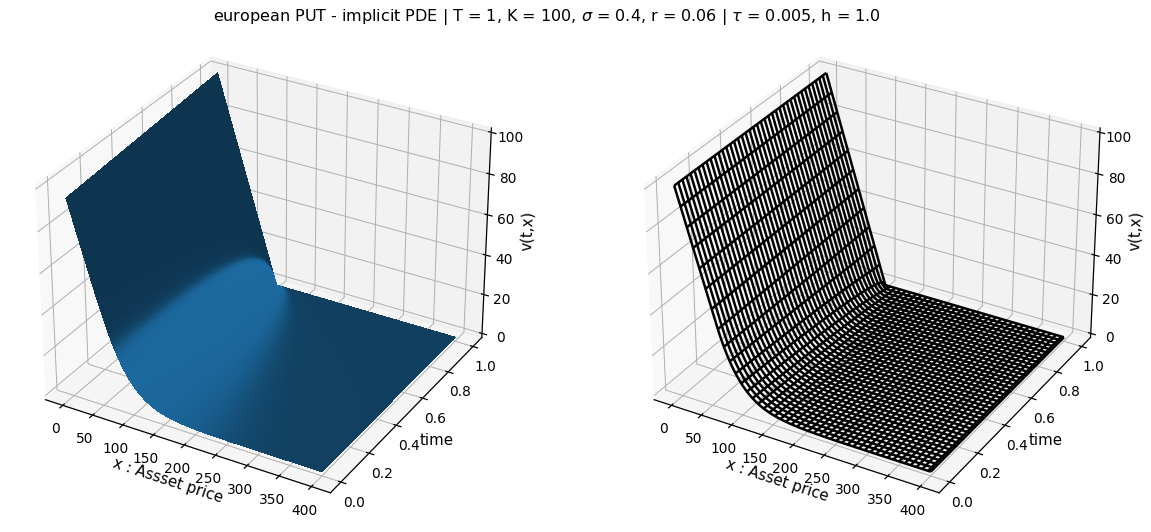

In [13]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection='3d') ; ax2 = fig.add_subplot(122,projection='3d')

fig.suptitle("european PUT - implicit PDE | T = {}, K = {}, $\sigma$ = {}, r = {} | $\\tau$ = {}, h = {}".format(T,K,sigma,r_input,tau,np.round(np.amax(np.diff(x)),3)), fontsize=16)
fig.subplots_adjust(top=1.1)

wirframe = ax2.plot_wireframe(x_mesh, t_mesh, V_imp_US, color = "black")
surf1 = ax1.plot_surface(x_mesh, t_mesh, V_imp_euro, rstride=1, cstride=1, linewidth=1.2, antialiased=False)

ax1.set_xlabel("x : Assset price") ; ax1.set_ylabel("time") ; ax1.set_zlabel("v(t,x)")
ax2.set_xlabel("x : Asset price") ; ax2.set_ylabel("time") ; ax2.set_zlabel("v(t,x)")

plt.savefig('Images/european PUT.png')
plt.show()

The evolution of our european put option seems very alike what we can find in the litterature. Our code seems to work great 

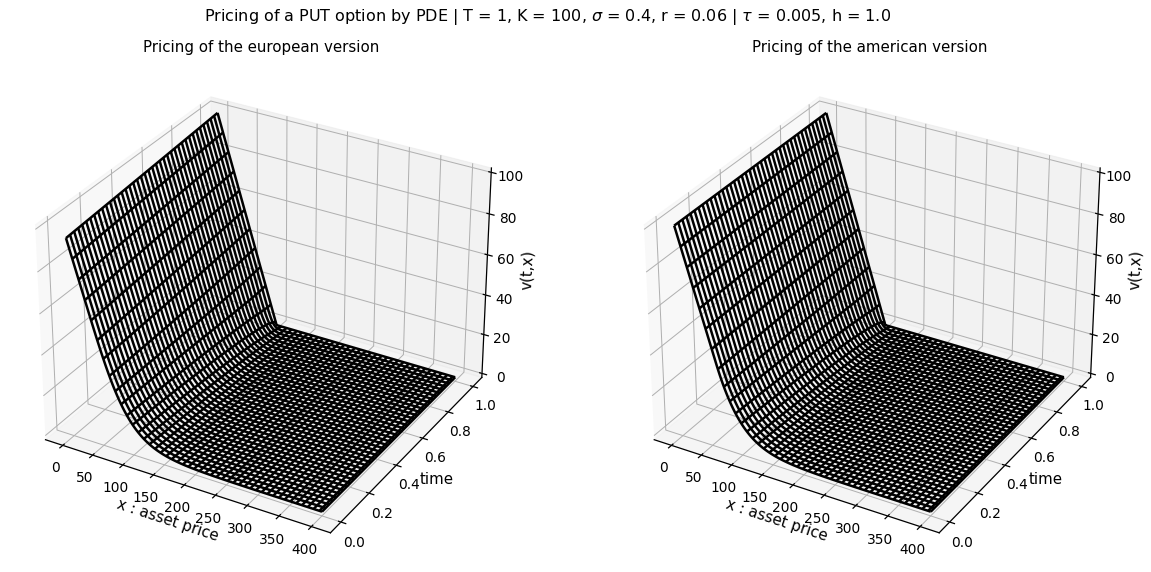

In [14]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection='3d'); ax2 = fig.add_subplot(122,projection='3d')

fig.suptitle("Pricing of a PUT option by PDE | T = {}, K = {}, $\sigma$ = {}, r = {} | $\\tau$ = {}, h = {}".format(T,K,sigma,r_input,tau,h), fontsize=16)
fig.subplots_adjust(top=0.99)

wirframe_euro = ax1.plot_wireframe(x_mesh, t_mesh, V_imp_euro, color = "black")
wirframe_americain = ax2.plot_wireframe(x_mesh, t_mesh, V_imp_US, color = "black")

ax1.set_xlabel("x : asset price") ; ax1.set_ylabel("time") ; ax1.set_zlabel("v(t,x)")
ax1.set_title("Pricing of the european version")

ax2.set_xlabel("x : asset price") ; ax2.set_ylabel("time") ; ax2.set_zlabel("v(t,x)")
ax2.set_title("Pricing of the american version")

plt.savefig('Images/european vs US put.png')
plt.show()

In [1]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(x,PAYOFF, label = "payoff", color = 'black')
ax2.plot(x,PAYOFF, label = "payoff", color = 'black')

for i in time_indx:
    ax1.plot(x,V_imp_euro[:,i],label = "t = {}".format(t[i]))
    ax2.plot(x,V_imp_US[:,i],label = "t = {}".format(t[i]))

    
fig.suptitle("Evolution of the price of a PUT option through time | PDE Implicit method | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}, h = {}".format(T,K,r_input,sigma,tau,h), fontsize=16)
fig.subplots_adjust(top=0.85)

ax1.grid() ; ax1.legend();
ax1.set_xlabel("asset price") ; ax1.set_ylabel("value")
ax1.set_title("european version")

ax2.grid() ; ax2.legend();
ax2.set_xlabel("asset price") ; ax2.set_ylabel("value")
ax2.set_title("american version")

plt.savefig('Images/price PUT through time.png')
plt.show()

NameError: name 'plt' is not defined

In [16]:
V_imp_roger_US = solve_PDE_implicit(x_min,x_max, K = 100,r = 0.06, T = 0.5, sigma = 0.4,  type_opt = 'US')

price_tab = [80,85,90,95,100,105,110,115,120]

price_indx = []
for value in price_tab:
    diff = [abs(val - value) for val in x]
    price_indx.append(diff.index(min(diff)))

In [17]:
price_roger = np.array([21.6059,18.0374,14.9187,12.2314,9.9458,8.0281,6.4352,5.1265,4.0611])
price_by_PDE = V_imp_roger_US[price_indx,0]
error = np.abs(price_by_PDE-price_roger)

In [18]:
df = pd.DataFrame(list(zip(price_tab, price_roger,price_by_PDE,error)),
               columns =['S0', 'American (true)', 'American (PDE)', 'error'])

In [19]:
print(df.to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
 S0 &  American (true) &  American (PDE) &    error \\
\midrule
 80 &          21.6059 &       21.593367 & 0.012533 \\
 85 &          18.0374 &       18.022612 & 0.014788 \\
 90 &          14.9187 &       14.902374 & 0.016326 \\
 95 &          12.2314 &       12.214351 & 0.017049 \\
100 &           9.9458 &        9.929712 & 0.016088 \\
105 &           8.0281 &        8.012113 & 0.015987 \\
110 &           6.4352 &        6.420956 & 0.014244 \\
115 &           5.1265 &        5.114325 & 0.012175 \\
120 &           4.0611 &        4.051312 & 0.009788 \\
\bottomrule
\end{tabular}



##### II.2.4 - Error of the scheme on the PDE

As stated earlier, the schema is supposed to be in in $\mathcal{O}(\Delta_t)$ and $\mathcal{O}(\Delta_x^2)$. We could say that as it's theoretical, we can just say it is. However something interesting to consider is that by computing the price of an american option, we can as well compute the price of it's european counterpart. Furthermore we've got analytical solutions of the price of an european PUT. Therefore we can study the error of our scheme on the european option to "validate" it. If it's good for this, it should be good for the american version. Furthermore a good thing about vanilla option in the black scholes framework is that we've got analytical formulas and therefore we can compute the error.

In [20]:
def BS_price_Put(S,K,r,sigma,T,t):
    d1 = (np.log(S/K) + (r+(sigma**2)/2)*(T-t))/(sigma*np.sqrt(T-t)) 
    d2 = d1 - sigma*np.sqrt(T-t)
    
    p = K*st.norm.cdf(-d2)*np.exp(-r*(T-t)) - S*st.norm.cdf(-d1) 
    return(p)

In [21]:
temp_0 = []
temp_1 = []
temp_2 = []
temp_3 = []

temp2_0 = []
temp2_1 = []
temp2_2 = []
temp2_3 = []
for S in x:
    temp_0.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[0]]))
    temp_1.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[1]]))
    temp_2.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[2]]))
    temp_3.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[3]]))
    
    temp2_0.append(BS_price_Put(S,K,high_rate,sigma,T,t[time_indx[0]]))
    temp2_1.append(BS_price_Put(S,K,high_rate,sigma,T,t[time_indx[1]]))
    temp2_2.append(BS_price_Put(S,K,high_rate,sigma,T,t[time_indx[2]]))
    temp2_3.append(BS_price_Put(S,K,high_rate,sigma,T,t[time_indx[3]]))

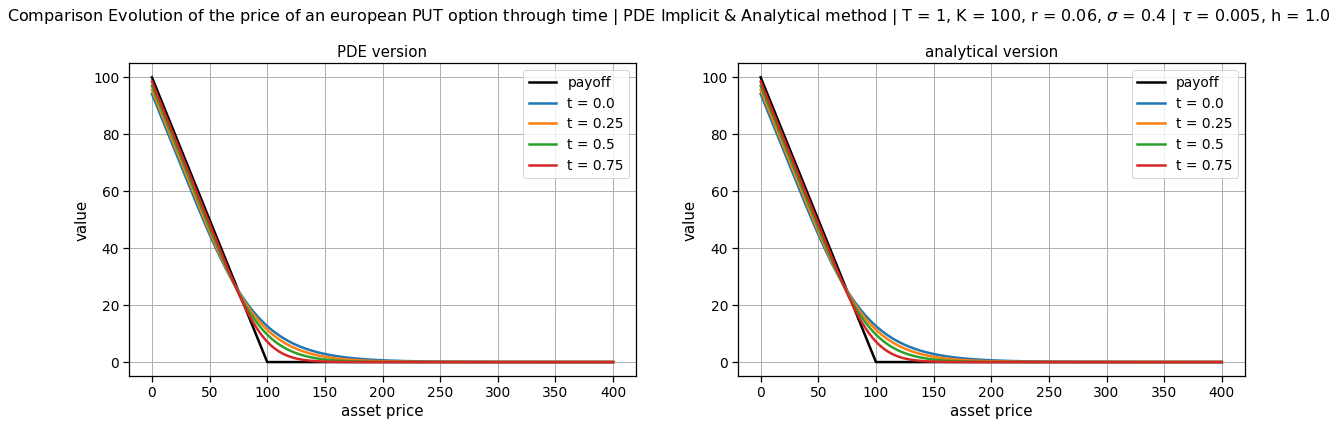

In [22]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(x,PAYOFF, label = "payoff", color = 'black')
ax2.plot(x,PAYOFF, label = "payoff", color = 'black')

for i in time_indx:
    ax1.plot(x,V_imp_euro[:,i],label = "t = {}".format(t[i]))

ax2.plot(x,temp_0, label = "t = {}".format(t[time_indx[0]]))
ax2.plot(x,temp_1, label = "t = {}".format(t[time_indx[1]]))
ax2.plot(x,temp_2, label = "t = {}".format(t[time_indx[2]]))
ax2.plot(x,temp_3, label = "t = {}".format(t[time_indx[3]]))

    
fig.suptitle("Comparison Evolution of the price of an european PUT option through time | PDE Implicit & Analytical method | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}, h = {}".format(T,K,r_input,sigma,tau,h), fontsize=16)
fig.subplots_adjust(top=0.85)

ax1.grid() ; ax1.legend();
ax1.set_xlabel("asset price") ; ax1.set_ylabel("value")
ax1.set_title("PDE version")

ax2.grid() ; ax2.legend();
ax2.set_xlabel("asset price") ; ax2.set_ylabel("value")
ax2.set_title("analytical version")

plt.savefig('Images/comparison analytic implicit put european.png')
plt.show()

In [23]:
err0 = V_imp_euro[:,time_indx[0]] - temp_0
err1 = V_imp_euro[:,time_indx[1]] - temp_1
err2 = V_imp_euro[:,time_indx[2]] - temp_2
err3 = V_imp_euro[:,time_indx[3]] - temp_3

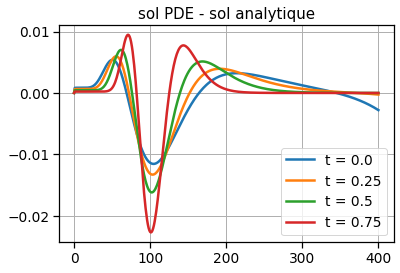

In [24]:
plt.plot(x,err0, label = "t = {}".format(t[time_indx[0]]))
plt.plot(x,err1, label = "t = {}".format(t[time_indx[1]]))
plt.plot(x,err2, label = "t = {}".format(t[time_indx[2]]))
plt.plot(x,err3, label = "t = {}".format(t[time_indx[3]]))

plt.title("sol PDE - sol analytique")
plt.grid() ; plt.legend() ; plt.show()

We will look at two different errors : 
- the $L_2$ error : 
$$
\begin{equation*}
    \varepsilon_2 = \sqrt{\frac{1}{n} \sum_{i=0}^{n} \left( u_i - \tilde{u}_i \right)^2 }
\end{equation*}
$$
- the $L_{\infty}$ error :
$$
\begin{equation*}
    \varepsilon_{\infty} = \underset{i \in [0,n]}{\sup} \left( | u_i - \tilde{u}_i | \right) 
\end{equation*}
$$
where $\tilde{u}$ denotes the exact solution of the european PUT option and $u_i$ the solution we got by finite difference.

In [25]:
n_arr = [100,200,300,500,800,1000,1500,2500,4000,5000,7000,8000,9000,10000]
h_arr = [(x_max-x_min)/n for n in n_arr]

err_L2_0 = []
err_L2_1 = []
err_L2_2 = []
err_L2_3 = []

err_abs_0 = []
err_abs_1 = []
err_abs_2 = []
err_abs_3 = []

t = np.linspace(0,T,m_pde+1)
val_to_find = [0,0.25,0.5,0.75]

computing_time = []

for i in range(len(n_arr)):
    
    t1 = time.time()
    V_EUR = solve_PDE_implicit(x_min,x_max,n = n_arr[i], type_opt = 'euro')
    t2 = time.time()
    
    computing_time.append(t2-t1)
    
    x_temp = np.linspace(x_min,x_max,n_arr[i]+1)
    h_temp = (x_max-x_min)/n_arr[i]
    analytic_0 = []
    analytic_1 = []
    analytic_2 = []
    analytic_3 = []
    

    for S in x_temp:
        analytic_0.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[0]]))
        analytic_1.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[1]]))
        analytic_2.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[2]]))
        analytic_3.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[3]]))
        
    diff = [abs(val - 200) for val in x_temp]
    arg_x_max = diff.index(min(diff))
    
    err_L2_0.append(np.sqrt(  np.mean( (V_EUR[:arg_x_max,time_indx[0]]-analytic_0[:arg_x_max])**2 ) ) )
    err_L2_1.append(np.sqrt(  np.mean( (V_EUR[:arg_x_max,time_indx[1]]-analytic_1[:arg_x_max])**2 ) ) )
    err_L2_2.append(np.sqrt(  np.mean( (V_EUR[:arg_x_max,time_indx[2]]-analytic_2[:arg_x_max])**2 ) ) )
    err_L2_3.append(np.sqrt(  np.mean( (V_EUR[:arg_x_max,time_indx[3]]-analytic_3[:arg_x_max])**2 ) ) )
    
    err_abs_0.append(np.amax(  np.abs( (V_EUR[:arg_x_max,time_indx[0]]-analytic_0[:arg_x_max]) ) ) )
    err_abs_1.append(np.amax(  np.abs( (V_EUR[:arg_x_max,time_indx[1]]-analytic_1[:arg_x_max]) ) ) )
    err_abs_2.append(np.amax(  np.abs( (V_EUR[:arg_x_max,time_indx[2]]-analytic_2[:arg_x_max]) ) ) )
    err_abs_3.append(np.amax(  np.abs( (V_EUR[:arg_x_max,time_indx[3]]-analytic_3[:arg_x_max]) ) ) )

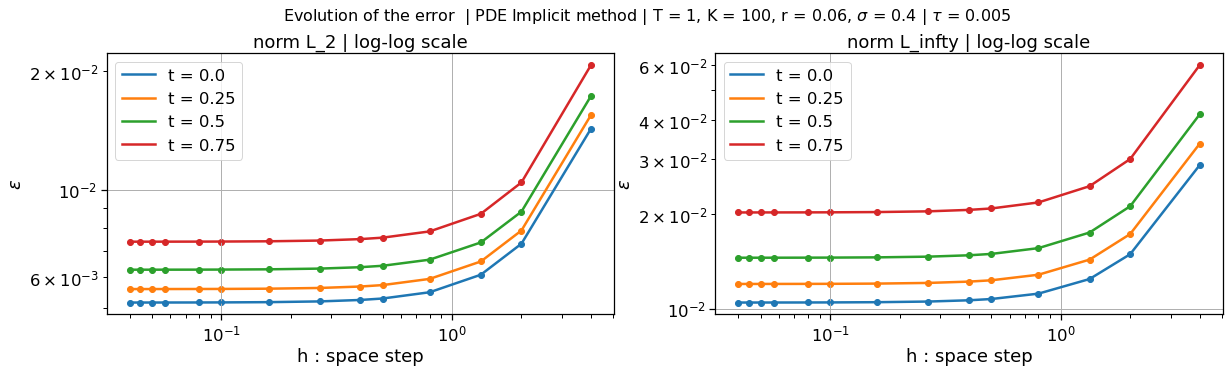

In [26]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(h_arr,err_L2_0, label ='t = {}'.format(t[time_indx[0]]))
ax1.plot(h_arr,err_L2_1, label ='t = {}'.format(t[time_indx[1]]))
ax1.plot(h_arr,err_L2_2, label ='t = {}'.format(t[time_indx[2]]))
ax1.plot(h_arr,err_L2_3, label ='t = {}'.format(t[time_indx[3]]))

ax1.scatter(h_arr,err_L2_0)
ax1.scatter(h_arr,err_L2_1)
ax1.scatter(h_arr,err_L2_2)
ax1.scatter(h_arr,err_L2_3)

ax2.plot(h_arr,err_abs_0, label ='t = {}'.format(t[time_indx[0]]))
ax2.plot(h_arr,err_abs_1, label ='t = {}'.format(t[time_indx[1]]))
ax2.plot(h_arr,err_abs_2, label ='t = {}'.format(t[time_indx[2]]))
ax2.plot(h_arr,err_abs_3, label ='t = {}'.format(t[time_indx[3]]))

ax2.scatter(h_arr,err_abs_0)
ax2.scatter(h_arr,err_abs_1)
ax2.scatter(h_arr,err_abs_2)
ax2.scatter(h_arr,err_abs_3)


fig.suptitle("Evolution of the error  | PDE Implicit method | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}".format(T,K,r_input,sigma,tau), fontsize=16)
fig.subplots_adjust(top=0.85)


ax1.set_yscale("log") ; ax1.set_xscale("log") ; ax2.set_yscale("log") ; ax2.set_xscale("log")

ax1.set_title("norm L_2 | log-log scale" )
ax2.set_title("norm L_infty | log-log scale" )

ax1.set_xlabel("h : space step") ; ax1.set_ylabel("$\epsilon$") 
ax2.set_xlabel("h : space step") ; ax2.set_ylabel("$\epsilon$") 
ax1.grid(); ax1.legend();
ax2.grid(); ax2.legend();

plt.savefig('Images/error PDE european.png')
plt.show()

stagnation of the error ? => linked to the size of the time step. The scheme is $\mathcal{O}(\tau)$ and $\mathcal{O}(h^2)$ therefore when on of the time step becomise significantly lower than the other, the other is dominant and drives the global error of the scheme.

##### II.2.5 - Proposition for a better solver

The numerical methods stated earlied are good but can be improved. Indeed we are doing specific matrix products and jsp quoi 

###### II.2.5.1 - Richardson extrapolation

The implicit scheme used earlier is stable in norm $L_2$ and $L_{\infty}$. It does not suffer from spurious oscillations as the Cranck-Nicholson scheme **(see Best of Willmott vol 2)**. However it has a big issue, the convergence in time is of $\mathcal{O}(\tau)$ whereas CN has a convergence in time of $\mathcal{O}(\tau^2)$. One way to overcome this issue is to apply the richardson extrapolation in time. 

$$
\begin{align*}
    v(t_j + \tau, x_i) &= v(t_j, x_i) + \tau \frac{\partial v}{\partial t}(t_j,x_i) + \frac{\tau^2}{2!} \frac{\partial^2 v}{\partial t^2}(t_j,x_i) + \frac{\tau^3}{3!} \frac{\partial^3 v}{\partial t^3} + \mathcal{O}(\tau^3) \\
    \Leftrightarrow \frac{v(t_j + \tau, x_i) - v(t_j, x_i)}{\tau} &= \frac{\partial v}{\partial t}(t_j,x_i) + \frac{\tau}{2!} \frac{\partial^2 v}{\partial t^2}(t_j,x_i) + \frac{\tau^2}{3!} \frac{\partial^3 v}{\partial t^3} + \mathcal{O}(\tau^2)
\end{align*}
$$

$$
\begin{align*}
    v(t_j + \frac{\tau}{2}, x_i) &= v(t_j, x_i) + \frac{\tau}{2} \frac{\partial v}{\partial t}(t_j,x_i) + \left(\frac{\tau}{2}\right)^2\frac{1}{2!} \frac{\partial^2 v}{\partial t^2}(t_j,x_i) + \left( \frac{\tau}{2} \right)^3 \frac{1}{3!} \frac{\partial^3 v}{\partial t^3} + \mathcal{O}(\tau^3) \\
    \Leftrightarrow \frac{v(t_j + \frac{\tau}{2}, x_i) - v(t_j, x_i)}{\frac{\tau}{2}} &= \frac{\partial v}{\partial t}(t_j,x_i) + \frac{\tau}{4} \frac{\partial^2 v}{\partial t^2}(t_j,x_i) + \left( \frac{\tau}{2} \right)^2 \frac{1}{3!} \frac{\partial^3 v}{\partial t^3} + \mathcal{O}(\tau^2)
\end{align*}
$$

One can remark that : 
$$
\begin{equation}
    \frac{\partial v}{\partial t}(t_j,x_i) = 2 \frac{v(t_j + \frac{\tau}{2}, x_i) - v(t_j, x_i)}{\frac{\tau}{2}} - \frac{v(t_j + \tau, x_i) - v(t_j, x_i)}{\tau} + \mathcal{O}(\tau^2)
\end{equation}
$$

Therefore solving the PDE with both time steps and combining them can give us a better time approximation

In [25]:
def solve_PDE_implicit_richardson(x_min, x_max,sigma = sigma, r = r_input, T = T , K = K, bound_min = bound_min, bound_max = bound_max, payoff = payoff_put , m = m_pde, n = n_pde, type_opt = 'euro'):
    
    t = np.linspace(0,T,m+1)
    x = np.linspace(x_min,x_max,n+1)
    
    V1 = solve_PDE_implicit(x_min, x_max,sigma, r, T, K, bound_min, bound_max, payoff, m, n, type_opt) #dt
    V2 = solve_PDE_implicit(x_min, x_max,sigma, r, T, K, bound_min, bound_max, payoff, 2*m, n, type_opt) #dt/2
    V_final = init_V(payoff,bound_min,bound_max,x,t,K,T,r,n,m) #final : O(\tau^2) + O(h^2)
            
    for j in range(m-1,-1,-1):    
        V_final[:,j] = 2*V2[:,2*j] - V1[:,j]
        
    return(V_final)

In [28]:
n_arr = [100,200,300,500,800,1000,1500,2500,4000,5000,7000,8000,9000,10000]
h_arr = [(x_max-x_min)/n for n in n_arr]

richardson_err_L2_0 = []
richardson_err_L2_1 = []
richardson_err_L2_2 = []
richardson_err_L2_3 = []

richardson_err_abs_0 = []
richardson_err_abs_1 = []
richardson_err_abs_2 = []
richardson_err_abs_3 = []

t = np.linspace(0,T,m_pde+1)
val_to_find = [0,0.25,0.5,0.75]

computing_time_richardson = []

for i in range(len(n_arr)):
    
    t1 = time.time()
    V_EUR = solve_PDE_implicit_richardson(x_min,x_max,n = n_arr[i], type_opt = 'euro')
    t2 = time.time()
    
    computing_time_richardson.append(t2-t1)
    
    x_temp = np.linspace(x_min,x_max,n_arr[i]+1)
    h_temp = (x_max-x_min)/n_arr[i]
    
    analytic_0 = []
    analytic_1 = []
    analytic_2 = []
    analytic_3 = []
        
    for S in x_temp:
        analytic_0.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[0]]))
        analytic_1.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[1]]))
        analytic_2.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[2]]))
        analytic_3.append(BS_price_Put(S,K,r_input,sigma,T,t[time_indx[3]]))
        
    diff = [abs(val - 200) for val in x_temp]
    arg_x_max = diff.index(min(diff))
    
    richardson_err_L2_0.append(np.sqrt(  np.mean( (V_EUR[:arg_x_max,time_indx[0]]-analytic_0[:arg_x_max])**2 ) ) )
    richardson_err_L2_1.append(np.sqrt(  np.mean( (V_EUR[:arg_x_max,time_indx[1]]-analytic_1[:arg_x_max])**2 ) ) )
    richardson_err_L2_2.append(np.sqrt(  np.mean( (V_EUR[:arg_x_max,time_indx[2]]-analytic_2[:arg_x_max])**2 ) ) )
    richardson_err_L2_3.append(np.sqrt(  np.mean( (V_EUR[:arg_x_max,time_indx[3]]-analytic_3[:arg_x_max])**2 ) ) )
    
    richardson_err_abs_0.append(np.amax(  np.abs( (V_EUR[:arg_x_max,time_indx[0]]-analytic_0[:arg_x_max]) ) ) )
    richardson_err_abs_1.append(np.amax(  np.abs( (V_EUR[:arg_x_max,time_indx[1]]-analytic_1[:arg_x_max]) ) ) )
    richardson_err_abs_2.append(np.amax(  np.abs( (V_EUR[:arg_x_max,time_indx[2]]-analytic_2[:arg_x_max]) ) ) )
    richardson_err_abs_3.append(np.amax(  np.abs( (V_EUR[:arg_x_max,time_indx[3]]-analytic_3[:arg_x_max]) ) ) )

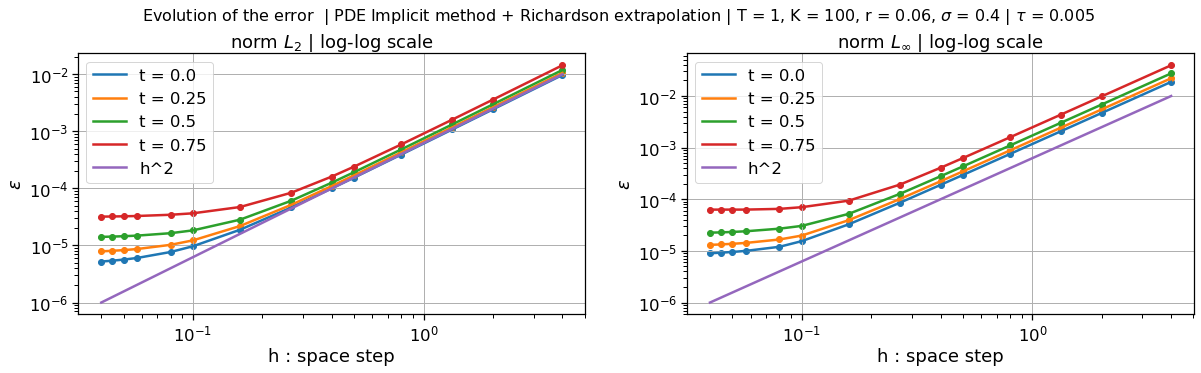

In [29]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(h_arr,richardson_err_L2_0, label ='t = {}'.format(t[time_indx[0]]))
ax1.plot(h_arr,richardson_err_L2_1, label ='t = {}'.format(t[time_indx[1]]))
ax1.plot(h_arr,richardson_err_L2_2, label ='t = {}'.format(t[time_indx[2]]))
ax1.plot(h_arr,richardson_err_L2_3, label ='t = {}'.format(t[time_indx[3]]))

h_arr = np.array(h_arr)
ax1.plot(h_arr,0.01/(h_arr[0]**2) * (h_arr**2), label = "h^2")

ax1.scatter(h_arr,richardson_err_L2_0)
ax1.scatter(h_arr,richardson_err_L2_1)
ax1.scatter(h_arr,richardson_err_L2_2)
ax1.scatter(h_arr,richardson_err_L2_3)

ax2.plot(h_arr,richardson_err_abs_0, label ='t = {}'.format(t[time_indx[0]]))
ax2.plot(h_arr,richardson_err_abs_1, label ='t = {}'.format(t[time_indx[1]]))
ax2.plot(h_arr,richardson_err_abs_2, label ='t = {}'.format(t[time_indx[2]]))
ax2.plot(h_arr,richardson_err_abs_3, label ='t = {}'.format(t[time_indx[3]]))

plt.plot(h_arr,0.01/(h_arr[0]**2) * (h_arr**2), label = "h^2")

ax2.scatter(h_arr,richardson_err_abs_0)
ax2.scatter(h_arr,richardson_err_abs_1)
ax2.scatter(h_arr,richardson_err_abs_2)
ax2.scatter(h_arr,richardson_err_abs_3)

fig.suptitle("Evolution of the error  | PDE Implicit method + Richardson extrapolation | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}".format(T,K,r_input,sigma,tau), fontsize=16)
fig.subplots_adjust(top=0.85)


ax1.set_yscale("log") ; ax1.set_xscale("log") ; ax2.set_yscale("log") ; ax2.set_xscale("log")

ax1.set_title("norm $L_2$ | log-log scale" )
ax2.set_title("norm $L_\infty$ | log-log scale" )

ax1.set_xlabel("h : space step") ; ax1.set_ylabel("$\epsilon$") 
ax2.set_xlabel("h : space step") ; ax2.set_ylabel("$\epsilon$") 
ax1.grid(); ax1.legend();
ax2.grid(); ax2.legend();

plt.savefig('Images/richardson extrapolation error.png')
plt.show()

As we can see, the error is largely inferior to what we had with just the implicit method. It's nearly quadratic. The only thing that stop it from being quadratic is one error linked to the space discretisation. Indeed when we posed the problem, we had to put ourselves in a grid. However one of the boundary condition is a limit. Therefore we introduced an error at this point and it drives the global error of the scheme.

Something we must as well take into account when we compare such methods is the time it takes to compute. Indeed we have a better convergence but how much does it change from a time consuming point of view. Well, let's take a look at it.

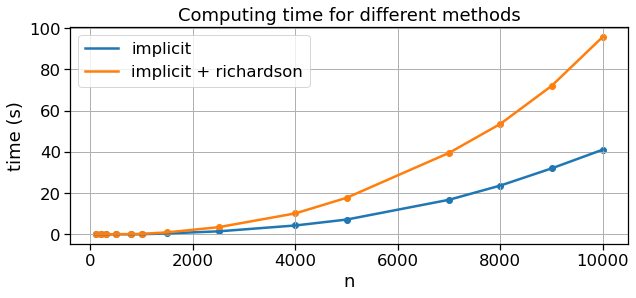

In [30]:
fig = plt.figure(figsize=(10,4))

plt.plot(n_arr, computing_time, label = 'implicit')
plt.plot(n_arr,computing_time_richardson, label = 'implicit + richardson')

plt.scatter(n_arr, computing_time)
plt.scatter(n_arr,computing_time_richardson)

plt.title("Computing time for different methods") ; plt.ylabel("time (s)") ; plt.xlabel("n")
plt.grid() ; plt.legend()

plt.savefig('Images/computing time.png')
plt.show()

###### II.2.5.2 - Direct Method : LU Decomposition

As stated earlier, when solving the finite difference scheme, we solve a linear system of the form : $AX = b$. We did it by inverting the matrix $A$. However in most cases, inverting a matrix is a bad idea has inverting a matrix necessit itself to solve a linear system and we might loose some nice property. Indeed in our case the matrix $A$ is tridiagonal but $A^{-1}$ doesn't have any reason to be tridiagonal as well. 

One of the first idea we can have is to look at how we solve the linear system. Indeed earlier we stated that we solve it by inverting the matrix A. In fact it's something really bad to do 

In [26]:
def solve_PDE_implicit_LU(x_min, x_max,sigma = sigma, r = r_input, T = T , K = K, bound_min = bound_min, bound_max = bound_max, payoff = payoff_put , m = m_pde, n = n_pde, type_opt = 'euro'):
    
    t = np.linspace(0,T,m+1)
    x = np.linspace(x_min,x_max,n+1)
    tau = T/m
    h = (x_max-x_min)/n
    
    a = (tau*r*x)/(2*h) - ((sigma**2)*(x**2)*tau)/(2*(h**2))
    b = ((sigma**2)*(x**2)*tau)/(h**2) + tau*r + 1
    c = -(tau*r*x)/(2*h) - ((sigma**2)*(x**2)*tau)/(2*(h**2))
    
    PAYOFF = payoff_put(x,K)
    
    V = init_V(payoff,bound_min,bound_max,x,t,K,T,r,n,m)
    A = computeA(a,b,c,n)
    lu, piv = lu_factor(A)
    
    for j in range(m-1,-1,-1):
        B = np.zeros(n-1)
        B[0] = a[1]*V[0,j]
        B[-1] = c[-1]*V[-1,j]
        V_temp = lu_solve((lu, piv), V[1:-1,j+1] - B) #solution of the PDE 
        if (type_opt == 'euro'):
            V[1:-1,j] = V_temp
        elif (type_opt == 'US'):
            V[1:-1,j] = np.maximum( V_temp , PAYOFF[1:-1] )
            V[0,j] = np.maximum(V[0,j], PAYOFF[0])
            V[-1,j] = np.maximum(V[-1,j], PAYOFF[-1])
        
    return(V)

In [27]:
def solve_PDE_implicit_richardson_LU(x_min, x_max,sigma = sigma, r = r_input, T = T , K = K, bound_min = bound_min, bound_max = bound_max, payoff = payoff_put , m = m_pde, n = n_pde, type_opt = 'euro'):
    
    t = np.linspace(0,T,m+1)
    x = np.linspace(x_min,x_max,n+1)
    
    V1 = solve_PDE_implicit_LU(x_min, x_max,sigma, r, T, K, bound_min, bound_max, payoff, m, n, type_opt) #dt
    V2 = solve_PDE_implicit_LU(x_min, x_max,sigma, r, T, K, bound_min, bound_max, payoff, 2*m, n, type_opt) #dt/2
    V_final = init_V(payoff,bound_min,bound_max,x,t,K,T,r,n,m) #final : O(\tau^2) + O(h^2)
            
    for j in range(m-1,-1,-1):    
        V_final[:,j] = 2*V2[:,2*j] - V1[:,j]
        
    return(V_final)

In [33]:
n_arr = [100,200,300,500,800,1000,1500,2500,4000,5000,7000,8000,9000,10000]
h_arr = [(x_max-x_min)/n for n in n_arr]

err_L2_0 = []
err_L2_1 = []
err_L2_2 = []
err_L2_3 = []

err_abs_0 = []
err_abs_1 = []
err_abs_2 = []
err_abs_3 = []

t = np.linspace(0,T,m_pde+1)
val_to_find = [0,0.25,0.5,0.75]

computing_time_LU = []
computing_time_richardson_LU = []
for i in range(len(n_arr)):
    
    t1 = time.time()
    V_EUR = solve_PDE_implicit_LU(x_min,x_max,n = n_arr[i], type_opt = 'euro')
    t2 = time.time()
    V_EUR = solve_PDE_implicit_richardson_LU(x_min,x_max,n = n_arr[i], type_opt = 'euro')
    t3 = time.time()
    
    computing_time_LU.append(t2-t1)
    computing_time_richardson_LU.append(t3-t2)

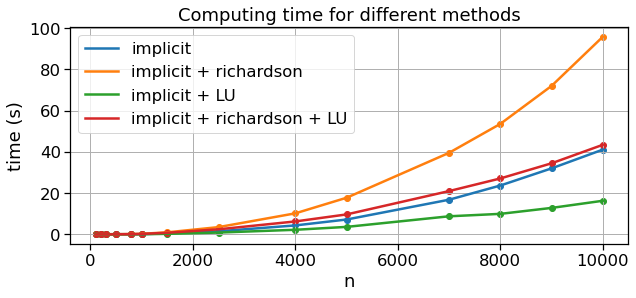

In [34]:
fig = plt.figure(figsize=(10,4))

plt.plot(n_arr, computing_time, label = 'implicit')
plt.plot(n_arr,computing_time_richardson, label = 'implicit + richardson')
plt.plot(n_arr,computing_time_LU, label = 'implicit + LU')
plt.plot(n_arr,computing_time_richardson_LU, label = 'implicit + richardson + LU')

plt.scatter(n_arr, computing_time)
plt.scatter(n_arr,computing_time_richardson)
plt.scatter(n_arr,computing_time_LU)
plt.scatter(n_arr,computing_time_richardson_LU)

plt.title("Computing time for different methods") ; plt.ylabel("time (s)") ; plt.xlabel("n")
plt.grid() ; plt.legend()

plt.savefig('Images/computing time updated.png')
plt.show()

As we can see, the simple fact of using the LU decomposition instead of inverting the matrix gives great results in term of computing time. The computing time has been divided by two, making the richardson extrapolation slighly more onerous than just the implicit method and therefore making it usable.

In [28]:
V_imp_roger_US_richardson_LU = solve_PDE_implicit_richardson_LU(x_min,x_max,n = n_pde,K = 100,r = 0.06, T = 0.5, sigma = 0.4,  type_opt = 'US')

price_tab = [80,85,90,95,100,105,110,115,120]

price_indx = []
for value in price_tab:
    diff = [abs(val - value) for val in x]
    price_indx.append(diff.index(min(diff)))
    
price_roger = np.array([21.6059,18.0374,14.9187,12.2314,9.9458,8.0281,6.4352,5.1265,4.0611])
price_by_PDE_richardson_LU = V_imp_roger_US_richardson_LU[price_indx,0]
error_richardson_LU = np.abs(price_by_PDE_richardson_LU-price_roger)

In [29]:
df = pd.DataFrame(list(zip(price_tab, price_roger,price_by_PDE,price_by_PDE_richardson_LU,error,error_richardson_LU)),
               columns =['S0', 'American (true)', 'American (PDE)','American (PDE + richardson)', 'error (PDE)','error (PDE + richardson)'])

In [30]:
df

,S0,American (true),American (PDE),American (PDE + richardson),error (PDE),error (PDE + richardson)
0,80,21.6059,21.593367,21.603865,0.012533,0.002035
1,85,18.0374,18.022612,18.034525,0.014788,0.002875
2,90,14.9187,14.902374,14.915291,0.016326,0.003409
3,95,12.2314,12.214351,12.227669,0.017049,0.003731
4,100,9.9458,9.929712,9.942759,0.016088,0.003041
5,105,8.0281,8.012113,8.024267,0.015987,0.003833
6,110,6.4352,6.420956,6.431724,0.014244,0.003476
7,115,5.1265,5.114325,5.123379,0.012175,0.003121
8,120,4.0611,4.051312,4.058502,0.009788,0.002598


In [31]:
print(df.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
 S0 &  American (true) &  American (PDE) &  American (PDE + richardson) &  error (PDE) &  error (PDE + richardson) \\
\midrule
 80 &          21.6059 &       21.593367 &                    21.603865 &     0.012533 &                  0.002035 \\
 85 &          18.0374 &       18.022612 &                    18.034525 &     0.014788 &                  0.002875 \\
 90 &          14.9187 &       14.902374 &                    14.915291 &     0.016326 &                  0.003409 \\
 95 &          12.2314 &       12.214351 &                    12.227669 &     0.017049 &                  0.003731 \\
100 &           9.9458 &        9.929712 &                     9.942759 &     0.016088 &                  0.003041 \\
105 &           8.0281 &        8.012113 &                     8.024267 &     0.015987 &                  0.003833 \\
110 &           6.4352 &        6.420956 &                     6.431724 &     0.014244 &                  0.003476 \\
115 &         

##### II.3 - The impact of interest rates

##### II.3.1 - Evolution of the price with different interest rates : european vs US PUT option

It could be interesting to look at the impact of the interest rate on the price of a PUT option. Indeed the interet rate plays a role in the drift of the asset. Therefore a interest rate should add a strong deterministic, positive and increasing with time tendency to the asset price and therefore make the price of the put option lower.

In [32]:
high_rate = 1
V_imp_euro_high_rate = solve_PDE_implicit_richardson_LU(x_min,x_max, r = high_rate, type_opt = 'euro')
V_imp_US_high_rate = solve_PDE_implicit_richardson_LU(x_min,x_max, r = high_rate, type_opt = 'US')

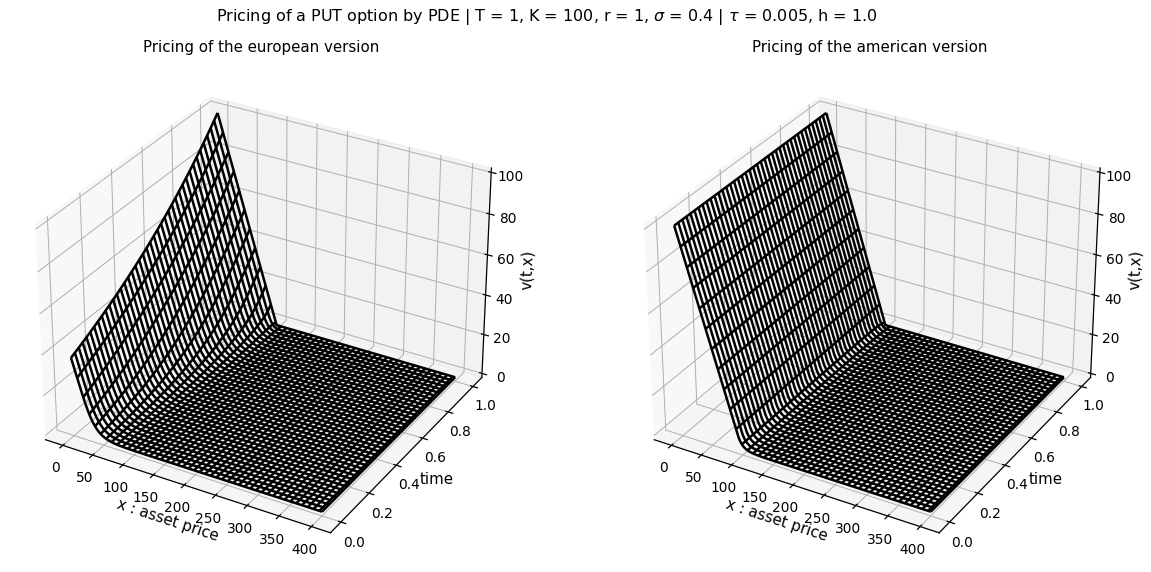

In [33]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection='3d'); ax2 = fig.add_subplot(122,projection='3d')

fig.suptitle("Pricing of a PUT option by PDE | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}, h = {}".format(T,K,high_rate,sigma,tau,h), fontsize=16)
fig.subplots_adjust(top=0.99)

wirframe_euro_high_r = ax1.plot_wireframe(x_mesh, t_mesh, V_imp_euro_high_rate, color = "black")
wirframe_US_high_r = ax2.plot_wireframe(x_mesh, t_mesh, V_imp_US_high_rate, color = "black")

ax1.set_xlabel("x : asset price") ; ax1.set_ylabel("time") ; ax1.set_zlabel("v(t,x)")
ax1.set_title("Pricing of the european version")

ax2.set_xlabel("x : asset price") ; ax2.set_ylabel("time") ; ax2.set_zlabel("v(t,x)")
ax2.set_title("Pricing of the american version")

plt.savefig('Images/put option high rate.png')
plt.show()

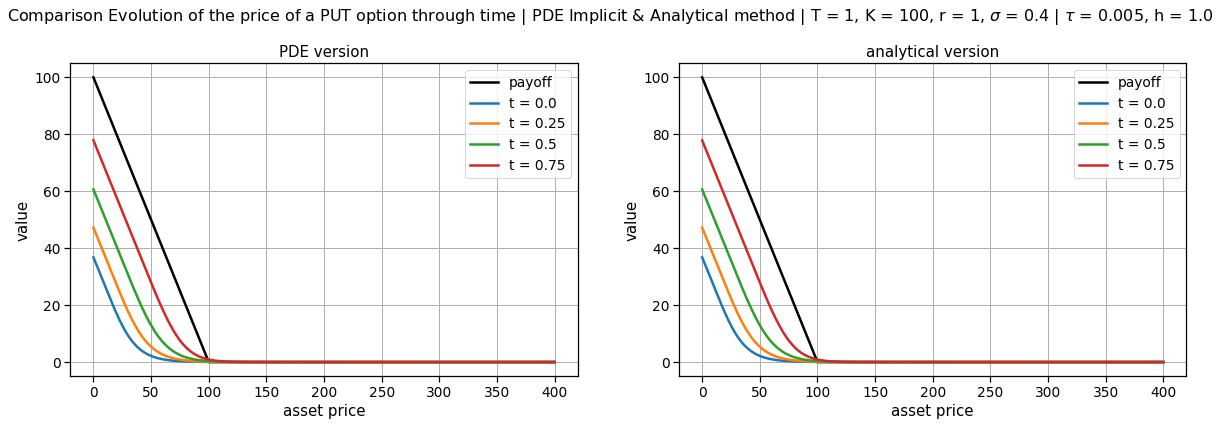

In [34]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(x,PAYOFF, label = "payoff", color = 'black')
ax2.plot(x,PAYOFF, label = "payoff", color = 'black')

for i in time_indx:
    ax1.plot(x,V_imp_euro_high_rate[:,i],label = "t = {}".format(t[i]))

ax2.plot(x,temp2_0, label = "t = {}".format(t[time_indx[0]]))
ax2.plot(x,temp2_1, label = "t = {}".format(t[time_indx[1]]))
ax2.plot(x,temp2_2, label = "t = {}".format(t[time_indx[2]]))
ax2.plot(x,temp2_3, label = "t = {}".format(t[time_indx[3]]))

    
fig.suptitle("Comparison Evolution of the price of a PUT option through time | PDE Implicit & Analytical method | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}, h = {}".format(T,K,high_rate,sigma,tau,h), fontsize=16)
fig.subplots_adjust(top=0.85)

ax1.grid() ; ax1.legend();
ax1.set_xlabel("asset price") ; ax1.set_ylabel("value")
ax1.set_title("PDE version")

ax2.grid() ; ax2.legend();
ax2.set_xlabel("asset price") ; ax2.set_ylabel("value")
ax2.set_title("analytical version")

plt.show()

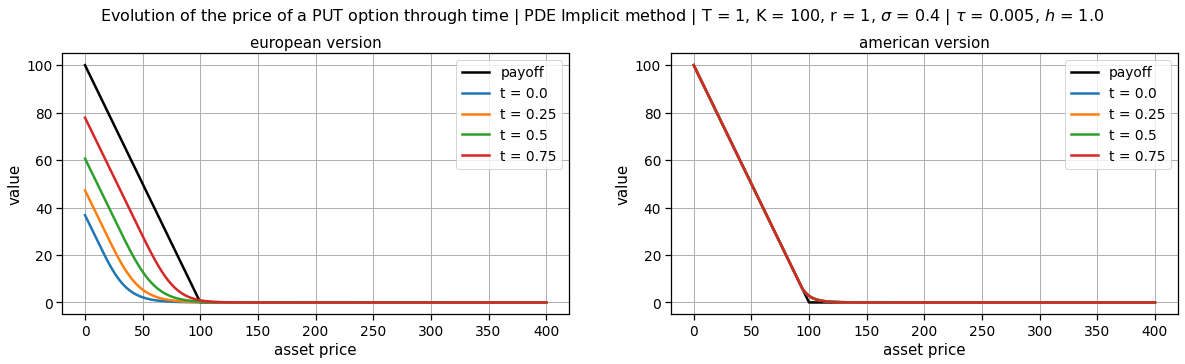

In [35]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(x,PAYOFF, label = "payoff", color = 'black')
ax2.plot(x,PAYOFF, label = "payoff", color = 'black')

for i in time_indx:
    ax1.plot(x,V_imp_euro_high_rate[:,i],label = "t = {}".format(t[i]))
    ax2.plot(x,V_imp_US_high_rate[:,i],label = "t = {}".format(t[i]))

    
fig.suptitle("Evolution of the price of a PUT option through time | PDE Implicit method | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}, $h$ = {}".format(T,K,high_rate,sigma,tau,h), fontsize=16)
fig.subplots_adjust(top=0.85)

ax1.grid() ; ax1.legend();
ax1.set_xlabel("asset price") ; ax1.set_ylabel("value")
ax1.set_title("european version")

ax2.grid() ; ax2.legend();
ax2.set_xlabel("asset price") ; ax2.set_ylabel("value")
ax2.set_title("american version")

plt.savefig('Images/price PUT through time.png')
plt.show()

As expected, the price of the european version is quite low. However for its US counterpart it's not low at all. Indeed with a high interest rate, it seems more interesting for an investor to early exercise his right and therefore the price is very often equal to the payoff. The only times it doesn't is near the strike from above as the price can't be the payoff because there is a chance for the asset to still end below the strike and therefore the option is still worth some grand.

##### II.3.2 - Continuation and Stopping region

Earlier we defined what we called the continuation and the stopping region. We can as well define a so called free boundary which is the curve which split in two our range of price during time such that if we are below the curve, it's optimal to stop and if we are above the curve, it's optimale to continue (i.e : not early exercise). Such free boundary can be found by for each $t \in [0,T]$, finding the price $S_t$ such that : $V(t,S_t) < \left( K - S_t \right)^{+}$.

In [40]:
m_test = 5000
n_test = 5000

x_test = np.linspace(x_min,x_max,n_test+1)
t_test = np.linspace(0,T,m_test+1)
PAYOFF = payoff_put(x_test,K)
PAYOFF = PAYOFF.reshape(len(PAYOFF),1)

In [88]:
r_arr = [0.05,0.1,0.2]

In [89]:
V_imp_euro_low_r = solve_PDE_implicit_richardson_LU(x_min,x_max, r = r_arr[0], m = m_test,n = n_test, type_opt = 'euro')
V_imp_euro_medium_r = solve_PDE_implicit_richardson_LU(x_min,x_max, r = r_arr[1], m = m_test,n = n_test, type_opt = 'euro')
V_imp_euro_high_r = solve_PDE_implicit_richardson_LU(x_min,x_max, r = r_arr[2], m = m_test,n = n_test, type_opt = 'euro')

In [90]:
diff_low_rate = (V_imp_euro_low_r - PAYOFF)[1:-1,:-1] 
diff_medium_rate = (V_imp_euro_medium_r - PAYOFF)[1:-1,:-1]
diff_high_rate = (V_imp_euro_high_r - PAYOFF)[1:-1,:-1]

In [91]:
max_indx_low_rate = np.argmax( diff_low_rate > 0, axis=0  )
max_indx_medium_rate = np.argmax( diff_medium_rate > 0, axis=0  )
max_indx_high_rate = np.argmax( diff_high_rate > 0, axis=0  )

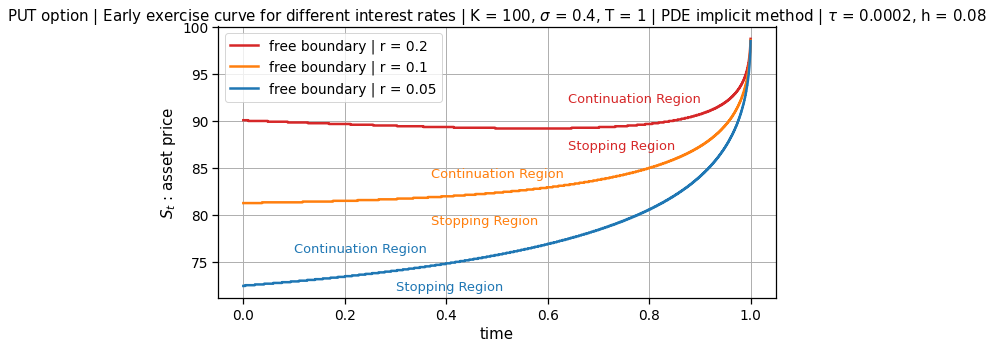

In [92]:
fig = plt.figure(figsize=(10,5))

plt.plot(t_test[:-1],x_test[max_indx_high_rate], label = "free boundary | r = {}".format(r_arr[2]), color = "tab:red")
plt.plot(t_test[:-1],x_test[max_indx_medium_rate], label = "free boundary | r = {}".format(r_arr[1]), color = "tab:orange")
plt.plot(t_test[:-1],x_test[max_indx_low_rate], label = "free boundary | r = {}".format(r_arr[0]), color = "tab:blue")

plt.text(0.64, 92, "Continuation Region", fontsize=13, color = "tab:red")
plt.text(0.64, 87, "Stopping Region", fontsize=13, color = "tab:red")

plt.text(0.37, 84, "Continuation Region", fontsize=13, color = "tab:orange")
plt.text(0.37, 79, "Stopping Region", fontsize=13, color = "tab:orange")

plt.text(0.1, 76, "Continuation Region", fontsize=13, color = "tab:blue")
plt.text(0.3, 72, "Stopping Region", fontsize=13, color = "tab:blue")

plt.title("PUT option | Early exercise curve for different interest rates | K = {}, $\sigma$ = {}, T = {} | PDE implicit method | $\\tau$ = {}, h = {}".format(K,sigma,T,T/m_test,round((x_max-x_min)/n_test,3)))
plt.xlabel("time") ; plt.ylabel("$S_t$ : asset price")
plt.grid() ; plt.legend();

plt.savefig('Images/free boundaries.png')
plt.show()

#### volatility effect 

In [36]:
low_vol = 0.1
high_vol = 0.5
V_imp_US_low_vol = solve_PDE_implicit_richardson_LU(x_min,x_max, sigma = low_vol, type_opt = 'US')
V_imp_US_high_vol = solve_PDE_implicit_richardson_LU(x_min,x_max, sigma = high_vol, type_opt = 'US')

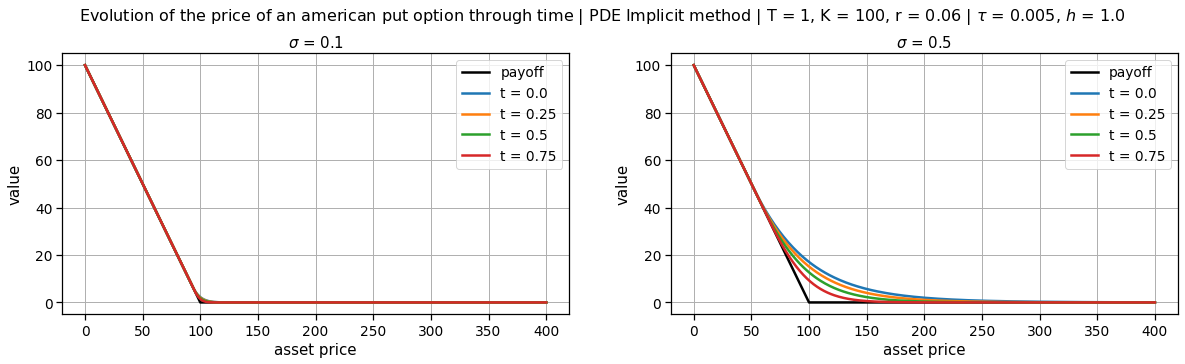

In [37]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(x,PAYOFF, label = "payoff", color = 'black')
ax2.plot(x,PAYOFF, label = "payoff", color = 'black')

for i in time_indx:
    ax1.plot(x,V_imp_US_low_vol[:,i],label = "t = {}".format(t[i]))
    ax2.plot(x,V_imp_US_high_vol[:,i],label = "t = {}".format(t[i]))

    
fig.suptitle("Evolution of the price of an american put option through time | PDE Implicit method | T = {}, K = {}, r = {} | $\\tau$ = {}, $h$ = {}".format(T,K,r_input,tau,h), fontsize=16)
fig.subplots_adjust(top=0.85)

ax1.grid() ; ax1.legend();
ax1.set_xlabel("asset price") ; ax1.set_ylabel("value")
ax1.set_title("$\sigma$ = {}".format(low_vol))

ax2.grid() ; ax2.legend();
ax2.set_xlabel("asset price") ; ax2.set_ylabel("value")
ax2.set_title("$\sigma$ = {}".format(high_vol))

plt.savefig('Images/price PUT through time.png')
plt.show()

In [38]:
vol_arr = [0.05,0.2,0.5]

In [41]:
V_imp_euro_low_vol = solve_PDE_implicit_richardson_LU(x_min,x_max, sigma = vol_arr[0], m = m_test,n = n_test, type_opt = 'euro')
V_imp_euro_medium_vol = solve_PDE_implicit_richardson_LU(x_min,x_max, sigma = vol_arr[1], m = m_test,n = n_test, type_opt = 'euro')
V_imp_euro_high_vol = solve_PDE_implicit_richardson_LU(x_min,x_max, sigma = vol_arr[2], m = m_test,n = n_test, type_opt = 'euro')

In [42]:
diff_low_vol = (V_imp_euro_low_vol - PAYOFF)[1:-1,:-1] 
diff_medium_vol = (V_imp_euro_medium_vol - PAYOFF)[1:-1,:-1]
diff_high_vol = (V_imp_euro_high_vol - PAYOFF)[1:-1,:-1]

In [43]:
max_indx_low_vol = np.argmax( diff_low_vol > 0, axis=0  )
max_indx_medium_vol = np.argmax( diff_medium_vol > 0, axis=0  )
max_indx_high_vol = np.argmax( diff_high_vol > 0, axis=0  )

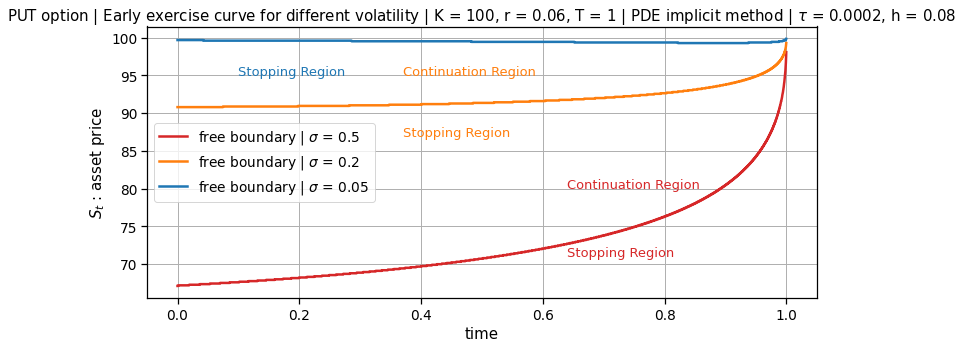

In [49]:
fig = plt.figure(figsize=(12,5))

plt.plot(t_test[:-1],x_test[max_indx_high_vol], label = "free boundary | $\sigma$ = {}".format(vol_arr[2]), color = "tab:red")
plt.plot(t_test[:-1],x_test[max_indx_medium_vol], label = "free boundary | $\sigma$ = {}".format(vol_arr[1]), color = "tab:orange")
plt.plot(t_test[:-1],x_test[max_indx_low_vol], label = "free boundary | $\sigma$ = {}".format(vol_arr[0]), color = "tab:blue")

plt.text(0.64, 80, "Continuation Region", fontsize=13, color = "tab:red")
plt.text(0.64, 71, "Stopping Region", fontsize=13, color = "tab:red")

plt.text(0.37, 95, "Continuation Region", fontsize=13, color = "tab:orange")
plt.text(0.37, 87, "Stopping Region", fontsize=13, color = "tab:orange")

plt.text(0.1, 95, "Stopping Region", fontsize=13, color = "tab:blue")

plt.title("PUT option | Early exercise curve for different volatility | K = {}, r = {}, T = {} | PDE implicit method | $\\tau$ = {}, h = {}".format(K,r_input,T,T/m_test,round((x_max-x_min)/n_test,3)))
plt.xlabel("time") ; plt.ylabel("$S_t$ : asset price")
plt.grid() ; plt.legend();

plt.savefig('Images/free boundaries volatility.png')
plt.show()

#### II.4 - Greeks

Whenever a bank trades a derivative product, it ends up with a position that has various sources of risks. Therefore to be able to hedge it, the bank need to understand where the risk lies and how it evolves.

To adress this problematic, we will need to know the sensitivity of a range accrual to the market parameters. These sensitivities are commonly referred to as the Greeks. We will look at the two most important greeks : the Delta and the Gamma which in the context of finance are respectively the quantity of asset one has to hold in a portfolio to perfectly replicate the derivative product and the gamma represent the speed at which one should re-balance his portfolio.

In [45]:
V_imp_euro = solve_PDE_implicit_richardson_LU(x_min,x_max, type_opt = 'euro')
V_imp_US = solve_PDE_implicit_richardson_LU(x_min,x_max, type_opt = 'US')

##### II.4.1 - Delta

The formula for the Delta is the following one : 
$$
\begin{equation}
    \Delta(t,x) = e^{-rt} K \mathcal{N}(-d_2) - x \mathcal{N}(-d_1)
\end{equation}
$$
We will approximate it with the following formula :
$$
\begin{equation}
    \Delta(t_j,x_i) = \frac{v_{i-1}^{j} - v_{i+1}^{j}}{2h}
\end{equation}
$$

In [55]:
def BS_delta_Put(S,K,r,sigma,T,t):
    d1 = (np.log(S/K) + (r+(sigma**2)/2)*(T-t))/(sigma*np.sqrt(T-t)) 
    
    delta = - st.norm.cdf(-d1) 
    return(delta)

In [56]:
delta_0 = []
delta_1 = []
delta_2 = []
delta_3 = []

for S in x:
    delta_0.append(BS_delta_Put(S,K,r_input,sigma,T,t[time_indx[0]]))
    delta_1.append(BS_delta_Put(S,K,r_input,sigma,T,t[time_indx[1]]))
    delta_2.append(BS_delta_Put(S,K,r_input,sigma,T,t[time_indx[2]]))
    delta_3.append(BS_delta_Put(S,K,r_input,sigma,T,t[time_indx[3]]))

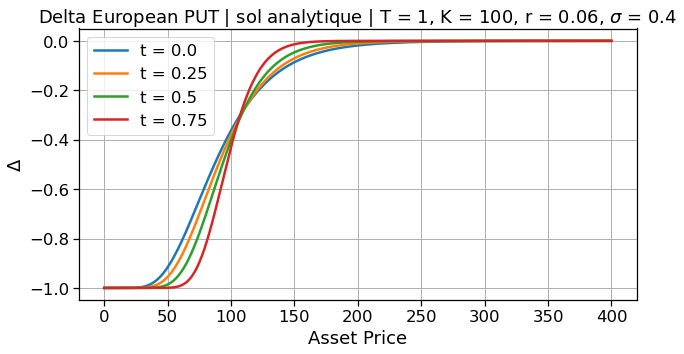

In [57]:
fig = plt.figure(figsize=(10,5))

plt.plot(x,delta_0, label = "t = {}".format(t[time_indx[0]]))
plt.plot(x,delta_1, label = "t = {}".format(t[time_indx[1]]))
plt.plot(x,delta_2, label = "t = {}".format(t[time_indx[2]]))
plt.plot(x,delta_3, label = "t = {}".format(t[time_indx[3]]))

plt.title("Delta European PUT | sol analytique | T = {}, K = {}, r = {}, $\sigma$ = {}".format(T,K,r_input,sigma))
plt.ylabel("$\Delta$") ; plt.xlabel("Asset Price")
plt.grid(); plt.legend() ; plt.show()

In [58]:
Delta_euro = np.zeros(V_imp_euro[2:,:m_pde-10].shape)
Delta_US = np.zeros(V_imp_US[2:,:m_pde-10].shape)
for j in range(m_pde-10):
    Delta_euro[:,j] = (V_imp_euro[2:,j] - V_imp_euro[:-2,j])/(2*h)
    Delta_US[:,j] = (V_imp_US[2:,j] - V_imp_US[:-2,j])/(2*h)

In [59]:
t_mesh2,x_mesh2 = np.meshgrid(t[:m_pde-10],x[1:-1])

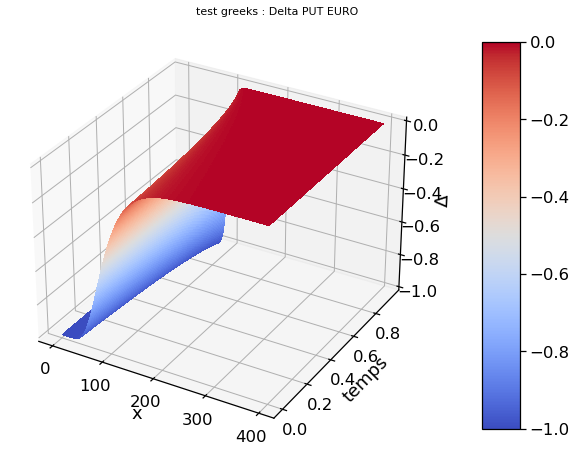

In [60]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(projection='3d')

fig.suptitle("test greeks : Delta PUT EURO", fontsize=11)
fig.subplots_adjust(top=1.2)

surf1 = ax1.plot_surface(x_mesh2, t_mesh2, Delta_euro, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=1.2, antialiased=False)
fig.colorbar(surf1, shrink=0.5, aspect=10, pad = 0.10) 

ax1.set_xlabel("x") ; ax1.set_ylabel("temps") ; ax1.set_zlabel("$\Delta$")
plt.show()

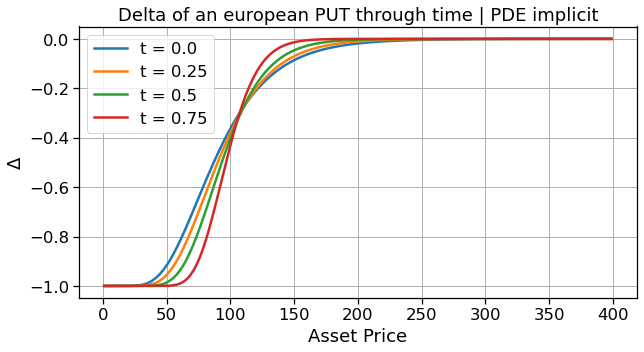

In [61]:
fig = plt.figure(figsize=(10,5))

plt.plot(x[1:-1],Delta_euro[:,time_indx[0]],label = "t = {}".format(t[time_indx[0]]))
plt.plot(x[1:-1],Delta_euro[:,time_indx[1]],label = "t = {}".format(t[time_indx[1]]))
plt.plot(x[1:-1],Delta_euro[:,time_indx[2]],label = "t = {}".format(t[time_indx[2]]))
plt.plot(x[1:-1],Delta_euro[:,time_indx[3]],label = "t = {}".format(t[time_indx[3]]))

plt.title("Delta of an european PUT through time | PDE implicit")
plt.ylabel("$\Delta$") ; plt.xlabel("Asset Price")
plt.grid(); plt.legend(); plt.show()

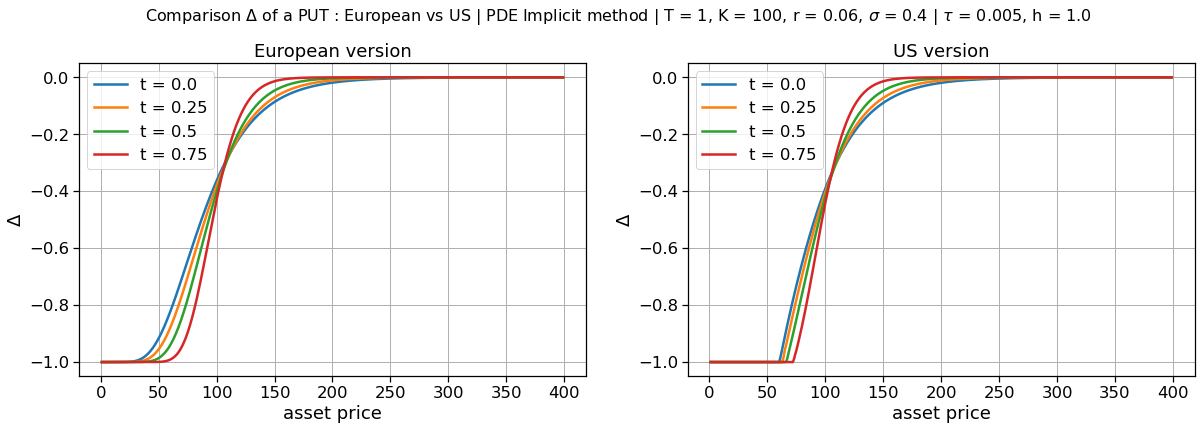

In [62]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)


ax1.plot(x[1:-1],Delta_euro[:,time_indx[0]],label = "t = {}".format(t[time_indx[0]]))
ax1.plot(x[1:-1],Delta_euro[:,time_indx[1]],label = "t = {}".format(t[time_indx[1]]))
ax1.plot(x[1:-1],Delta_euro[:,time_indx[2]],label = "t = {}".format(t[time_indx[2]]))
ax1.plot(x[1:-1],Delta_euro[:,time_indx[3]],label = "t = {}".format(t[time_indx[3]]))

ax2.plot(x[1:-1],Delta_US[:,time_indx[0]],label = "t = {}".format(t[time_indx[0]]))
ax2.plot(x[1:-1],Delta_US[:,time_indx[1]],label = "t = {}".format(t[time_indx[1]]))
ax2.plot(x[1:-1],Delta_US[:,time_indx[2]],label = "t = {}".format(t[time_indx[2]]))
ax2.plot(x[1:-1],Delta_US[:,time_indx[3]],label = "t = {}".format(t[time_indx[3]]))

    
fig.suptitle("Comparison $\Delta$ of a PUT : European vs US | PDE Implicit method | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}, h = {}".format(T,K,r_input,sigma,tau,h), fontsize=16)
fig.subplots_adjust(top=0.85)

ax1.grid() ; ax1.legend();
ax1.set_xlabel("asset price") ; ax1.set_ylabel("$\Delta$")
ax1.set_title("European version")

ax2.grid() ; ax2.legend();
ax2.set_xlabel("asset price") ; ax2.set_ylabel("$\Delta$")
ax2.set_title("US version")

plt.savefig('Images/delta put.png')
plt.show()

As one can see, the Delta of an european and american PUT option are different. Indeed when we are near the strike, there is no reason to early exercise because the asset price could still go lower and therefore it acts like it's european counterpart. However when we are further away from the strike from below, the holder of the option will early exercise therefore for the delta is constant.

##### II.4.2 - Gamma

The formula for the Gamma is the following one : 
$$
\begin{equation}
    \Gamma(t,x) = \frac{\phi(d_1)}{x \sigma \sqrt{T-t}}
\end{equation}
$$
We will approximate it with the following formula :
$$
\begin{equation}
    \Gamma(t_j,x_i) = \frac{ v^j_{i-1} - 2 v^j_{i} + v^j_{i+1}}{h^2}
\end{equation}
$$

In [75]:
def BS_gamma_Put(S,K,r,sigma,T,t):
    d1 = (np.log(S/K) + (r+(sigma**2)/2)*(T-t))/(sigma*np.sqrt(T-t)) 
    
    Gamma = st.norm.pdf(d1)/(S*sigma*np.sqrt(T-t))
    return(Gamma)

In [76]:
Gamma_0 = []
Gamma_1 = []
Gamma_2 = []
Gamma_3 = []

for S in x:
    Gamma_0.append(BS_gamma_Put(S,K,r_input,sigma,T,t[time_indx[0]]))
    Gamma_1.append(BS_gamma_Put(S,K,r_input,sigma,T,t[time_indx[1]]))
    Gamma_2.append(BS_gamma_Put(S,K,r_input,sigma,T,t[time_indx[2]]))
    Gamma_3.append(BS_gamma_Put(S,K,r_input,sigma,T,t[time_indx[3]]))

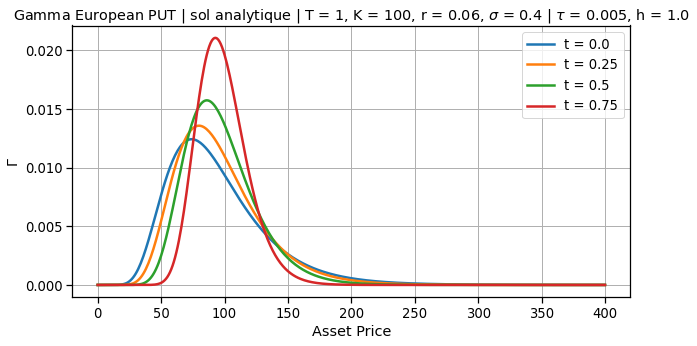

In [77]:
fig = plt.figure(figsize=(10,5))

plt.plot(x,Gamma_0, label = "t = {}".format(t[time_indx[0]]))
plt.plot(x,Gamma_1, label = "t = {}".format(t[time_indx[1]]))
plt.plot(x,Gamma_2, label = "t = {}".format(t[time_indx[2]]))
plt.plot(x,Gamma_3, label = "t = {}".format(t[time_indx[3]]))

plt.title("Gamma European PUT | sol analytique | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}, h = {}".format(T,K,r_input,sigma,tau,h))
plt.ylabel("$\Gamma$") ; plt.xlabel("Asset Price")
plt.grid(); plt.legend() ; plt.show()

In [78]:
Gamma_euro = np.zeros(V_imp_euro[2:,:m_pde-10].shape)
Gamma_US = np.zeros(V_imp_US[2:,:m_pde-10].shape)
for j in range(m_pde-10):
    Gamma_euro[:,j] = (V_imp_euro[2:,j] -2*V_imp_euro[1:-1,j] + V_imp_euro[:-2,j])/(h**2)
    Gamma_US[:,j] = (V_imp_US[2:,j] -2*V_imp_US[1:-1,j] + V_imp_US[:-2,j])/(h**2)

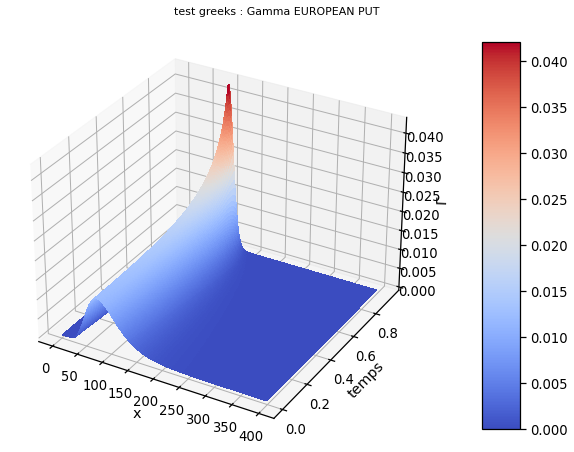

In [79]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(projection='3d')

fig.suptitle("test greeks : Gamma EUROPEAN PUT", fontsize=11)
fig.subplots_adjust(top=1.2)

surf1 = ax1.plot_surface(x_mesh2, t_mesh2, Gamma_euro, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=1.2, antialiased=False)
fig.colorbar(surf1, shrink=0.5, aspect=10, pad = 0.10) 

ax1.set_xlabel("x") ; ax1.set_ylabel("temps") ; ax1.set_zlabel("$\Gamma$")
plt.show()

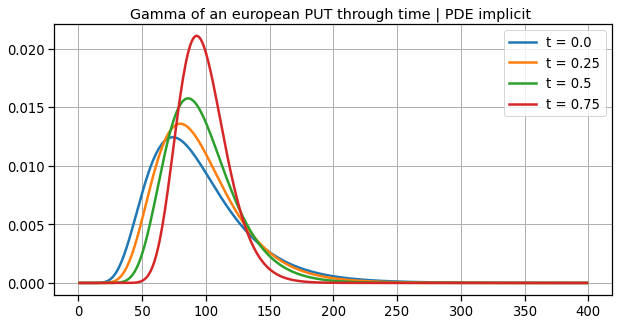

In [80]:
fig = plt.figure(figsize=(10,5))

plt.plot(x[1:-1],Gamma_euro[:,time_indx[0]],label = "t = {}".format(t[time_indx[0]]))
plt.plot(x[1:-1],Gamma_euro[:,time_indx[1]],label = "t = {}".format(t[time_indx[1]]))
plt.plot(x[1:-1],Gamma_euro[:,time_indx[2]],label = "t = {}".format(t[time_indx[2]]))
plt.plot(x[1:-1],Gamma_euro[:,time_indx[3]],label = "t = {}".format(t[time_indx[3]]))

plt.title("Gamma of an european PUT through time | PDE implicit ")
plt.grid(); plt.legend(); plt.show()

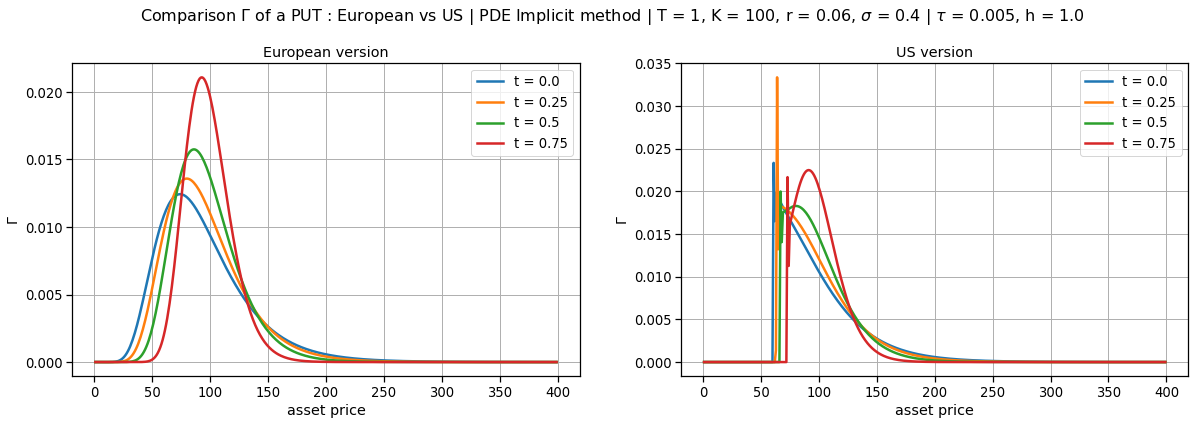

In [81]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)


ax1.plot(x[1:-1],Gamma_euro[:,time_indx[0]],label = "t = {}".format(t[time_indx[0]]))
ax1.plot(x[1:-1],Gamma_euro[:,time_indx[1]],label = "t = {}".format(t[time_indx[1]]))
ax1.plot(x[1:-1],Gamma_euro[:,time_indx[2]],label = "t = {}".format(t[time_indx[2]]))
ax1.plot(x[1:-1],Gamma_euro[:,time_indx[3]],label = "t = {}".format(t[time_indx[3]]))

ax2.plot(x[1:-1],Gamma_US[:,time_indx[0]],label = "t = {}".format(t[time_indx[0]]))
ax2.plot(x[1:-1],Gamma_US[:,time_indx[1]],label = "t = {}".format(t[time_indx[1]]))
ax2.plot(x[1:-1],Gamma_US[:,time_indx[2]],label = "t = {}".format(t[time_indx[2]]))
ax2.plot(x[1:-1],Gamma_US[:,time_indx[3]],label = "t = {}".format(t[time_indx[3]]))

    
fig.suptitle("Comparison $\Gamma$ of a PUT : European vs US | PDE Implicit method | T = {}, K = {}, r = {}, $\sigma$ = {} | $\\tau$ = {}, h = {}".format(T,K,r_input,sigma,tau,h), fontsize=16)
fig.subplots_adjust(top=0.85)

ax1.grid() ; ax1.legend();
ax1.set_xlabel("asset price") ; ax1.set_ylabel("$\Gamma$")
ax1.set_title("European version")

ax2.grid() ; ax2.legend();
ax2.set_xlabel("asset price") ; ax2.set_ylabel("$\Gamma$")
ax2.set_title("US version")

plt.savefig('Images/gamma put.png')
plt.show()

As one can see, the Gamma of an european and american PUT option are different. Indeed due to the fact that an american option can be early exercised, there is a strong variation of the Gamma around the strike because if we are far away from below, the holder early exercise but as we get closer the the strike, the US option acts like the european counterpart and therefore the gamma goes from 0 to the value of the european gamma.